In [132]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_absolute_error as MAE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import plot_tree

In [72]:
# VISUALS
# Figure size
plt.rcParams['figure.figsize'] = [16,10]

# Text sizes
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.labelsize']= 12
plt.rcParams['font.size'] = 14

# Colors
plt.rcParams['legend.labelcolor'] = '#000000'
plt.rcParams['xtick.labelcolor'] = '#000000'
plt.rcParams['ytick.labelcolor'] = '#000000'
plt.rcParams['axes.labelcolor'] = '#000000'
plt.rcParams['axes.titlecolor'] = '#000000'
plt.rcParams['axes.edgecolor'] = '#000000'
plt.rcParams['xtick.color'] = '#000000'
plt.rcParams['ytick.color'] = '#000000'
plt.rcParams['figure.facecolor'] = '#ffffff'
plt.rcParams['axes.facecolor'] = '#ffffff'

# Graph colors
from cycler import cycler

diverse = ['#1f78b4', '#33a02c', '#e31a1c', '#ff7f00', '#6a3d9a', '#b15928', '#a6cee3', '#b2df8a', '#fb9a99']
greens = ['#2ca02c', '#4daf4a', '#45a05a', '#60bd68', '#5cb85c', '#6ba981', '#75bb6f', '#6dae64', '#4c9a5f']
blues = ['#1f78b4', '#377eb8', '#3182bd', '#4292c6', '#5aaed6', '#6baed6', '#7ba3df', '#92b3e4', '#a6bddb']
reds = ['#e41a1c', '#d73027', '#a50026', '#f46d43', '#d73027', '#fdae61', '#fee08b', '#fee08b', '#d73027']

plt.rcParams['axes.prop_cycle'] = cycler(color = diverse)

# Display max columns, pandas dataframes
pd.set_option('display.max_columns', None) 

Importing data and separating into independent and dependent variables. Further into training and test sets.

In [3]:
df = pd.read_csv('../Felles/TrondheimHousingDataCleaned.csv')

In [4]:
X = df.select_dtypes(include = ['int', 'float']).drop(columns = ['Price', 'Total price at last sale'])
y = df['Total price at last sale']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = 42)

Creating the benchmark model without intervention.

In [17]:
model_0 = DecisionTreeRegressor(random_state = 42).fit(X_train, y_train)

print('Train score:\t', model_0.score(X_train, y_train))
print('Test score:\t', model_0.score(X_test, y_test))

Train score:	 0.9977816513900539
Test score:	 0.7492187556092926


In [133]:
model_0_pred_train = model_0.predict(X_train)
model_0_pred_test = model_0.predict(X_test)

print('MAE on train:\t', MAE(y_train, model_0_pred_train))
print('MAE on test:\t', MAE(y_test, model_0_pred_test))

MAE on train:	 8111.961612548466
MAE on test:	 556060.3487598449


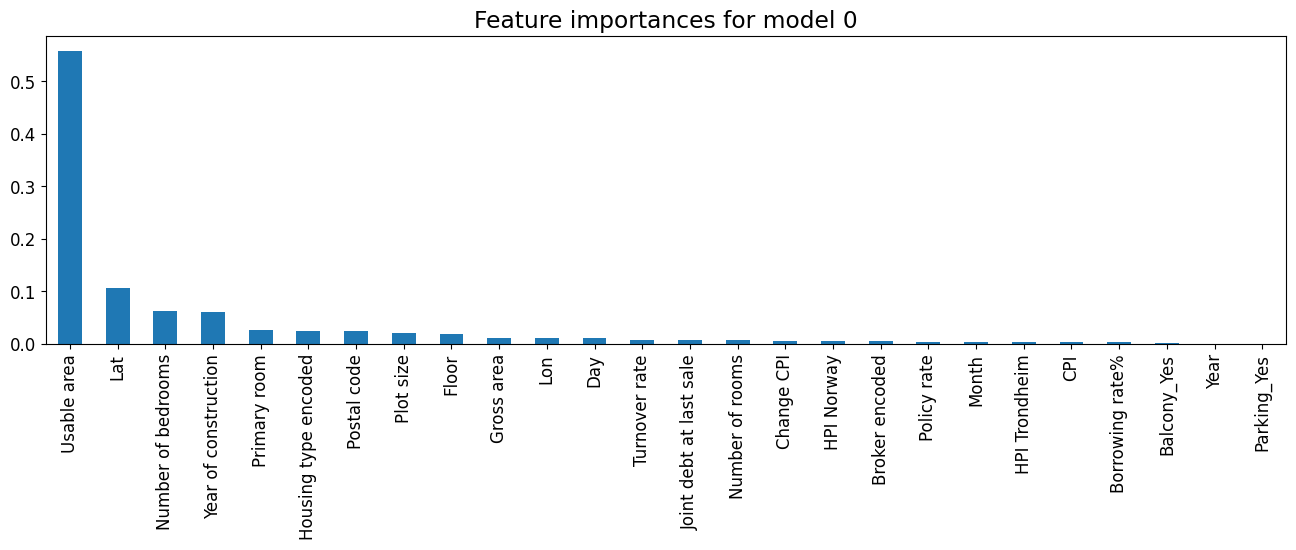

In [161]:
importances_m0 = pd.DataFrame(model_0.feature_importances_,
                              columns = ['Importances'],
                              index = X_train.columns)
importances_m0.sort_values(by = ['Importances'], axis = 0,
                           ascending = False, inplace = True)

importances_m0['Importances'].plot(kind = 'bar', figsize = (16, 4))
plt.title('Feature importances for model 0')
plt.show()

Performing a grid search with five fold cross validation to find optimal hyperparameters for pre pruning.

In [18]:
grid = {
    'max_depth': [5, 10, 15, 20, 25, 30],
    'min_samples_split': [5, 10, 15, 20, 25, 30],
    'min_samples_leaf': [5, 10, 15, 20, 25, 30]
}

grid_search = GridSearchCV(estimator = DecisionTreeRegressor(random_state = 42), 
                           param_grid = grid, 
                           scoring = 'neg_mean_squared_error', 
                           cv = 5)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

{'max_depth': 15, 'min_samples_leaf': 20, 'min_samples_split': 5}


Defining the pre pruned model.

In [19]:
model_1 = DecisionTreeRegressor(random_state = 42, **grid_search.best_params_).fit(X_train, y_train)

print('Train score:\t', model_1.score(X_train, y_train))
print('Test score:\t', model_1.score(X_test, y_test))

Train score:	 0.849633942105946
Test score:	 0.8121212099008169


In [134]:
model_1_pred_train = model_1.predict(X_train)
model_1_pred_test = model_1.predict(X_test)

print('MAE on train:\t', MAE(y_train, model_1_pred_train))
print('MAE on test:\t', MAE(y_test, model_1_pred_test))

MAE on train:	 449919.13004740444
MAE on test:	 526805.377890552


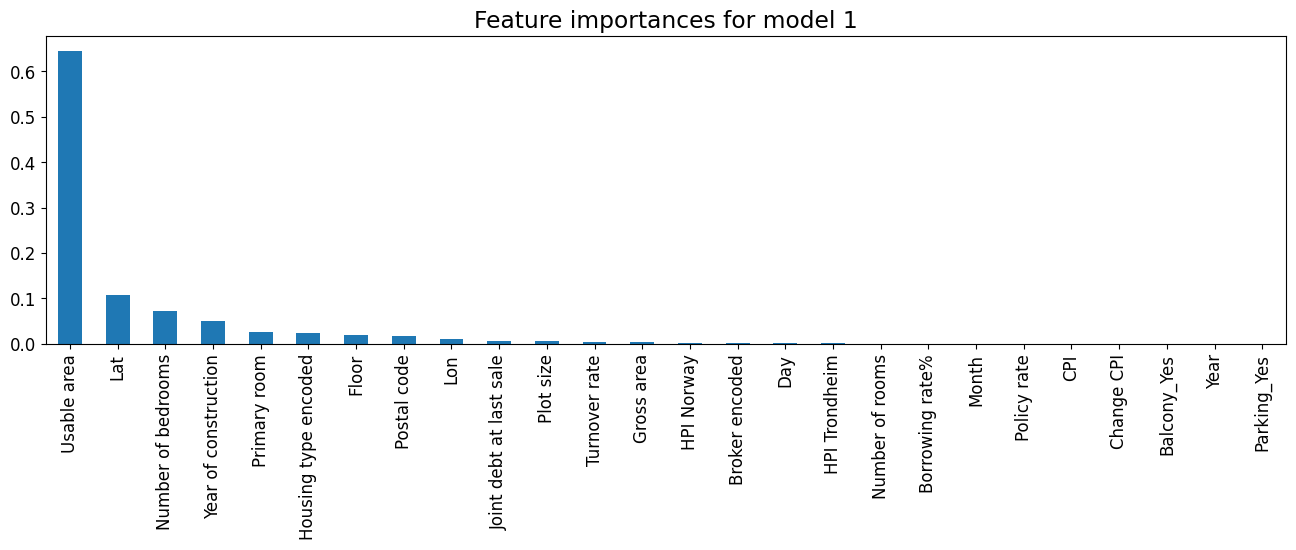

In [159]:
importances_m1 = pd.DataFrame(model_1.feature_importances_,
                           columns = ['Importances'],
                           index = X_train.columns)
importances_m1.sort_values(by = ['Importances'], axis = 0,
                        ascending = False, inplace = True)

importances_m1['Importances'].plot(kind = 'bar', figsize = (16, 4))
plt.title('Feature importances for model 1')
plt.show()

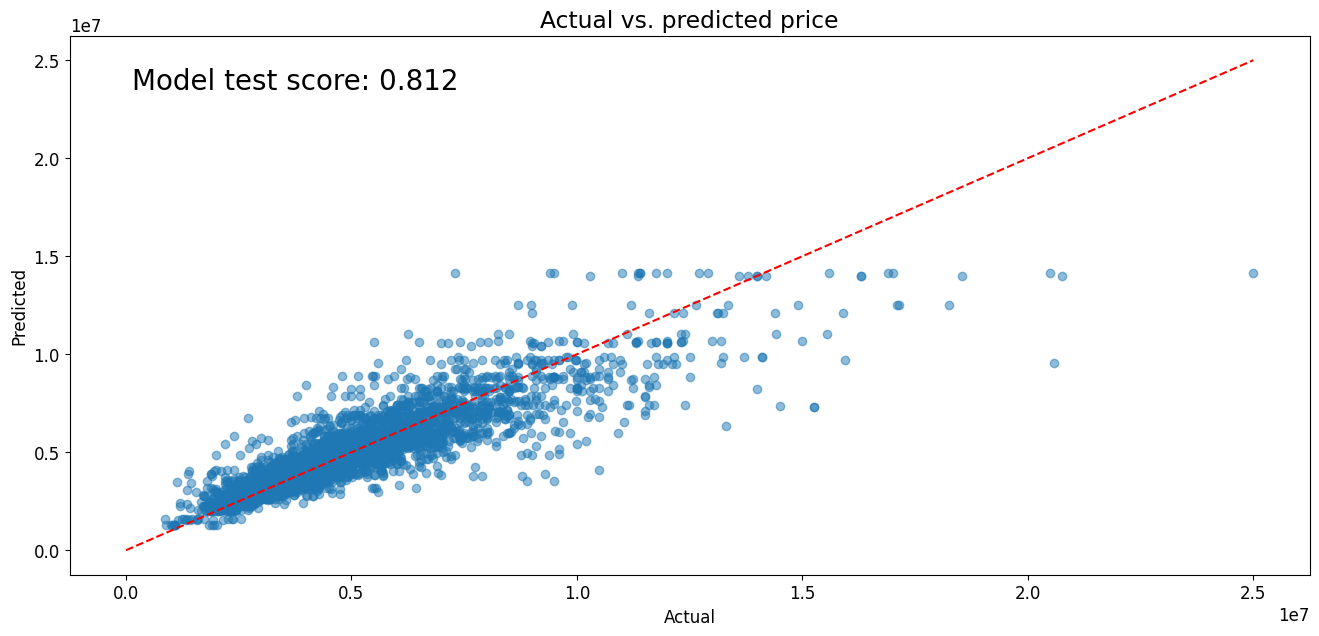

In [176]:
plt.figure(figsize = (16, 7))
plt.scatter(y_test, model_1_pred_test, alpha = .5)
plt.plot(np.linspace(0, y_test.max(), num = 2),
         np.linspace(0, y_test.max(), num = 2),
         color = 'red', linestyle = '--')

plt.text(0.05, 0.9, f'Model test score: {model_1.score(X_test, y_test):.3f}',
         transform=plt.gca().transAxes, fontsize=20, ha='left')

plt.title('Actual vs. predicted price')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

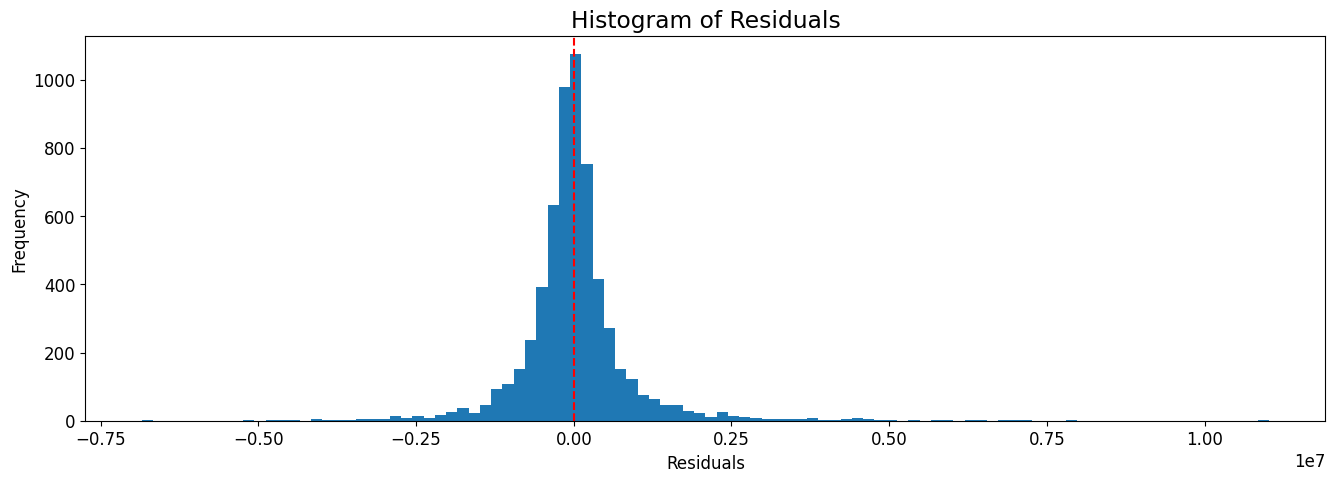

In [188]:
plt.figure(figsize = (16, 5))
plt.hist(y_test - model_1_pred_test, bins = 100)
plt.axvline(0, color = 'red', linestyle = '--')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

Starting minimal cost complexity pruning on both models. Defining the pruning paths and extracting their repsective alphas.

In [95]:
pruning_paths_0 = model_0.cost_complexity_pruning_path(X_train, y_train)
pruning_paths_1 = model_1.cost_complexity_pruning_path(X_train, y_train)

alphas_0 = pruning_paths_0.ccp_alphas
alphas_1 = pruning_paths_1.ccp_alphas

In [96]:
print('Model 0:', len(alphas_0))
print('Model 1:', len(alphas_1))

Model 0: 11859
Model 1: 490


In [97]:
print('Model 0 min/max:', alphas_0.min(), alphas_0.max())
print('Model 1 min/max:', alphas_1.min(), alphas_1.max())

Model 0 min/max: 0.0 1639765064815.7715
Model 1 min/max: 0.0 1639765064815.7715


To save on computational costs, we will narrow down the interval of alphas.

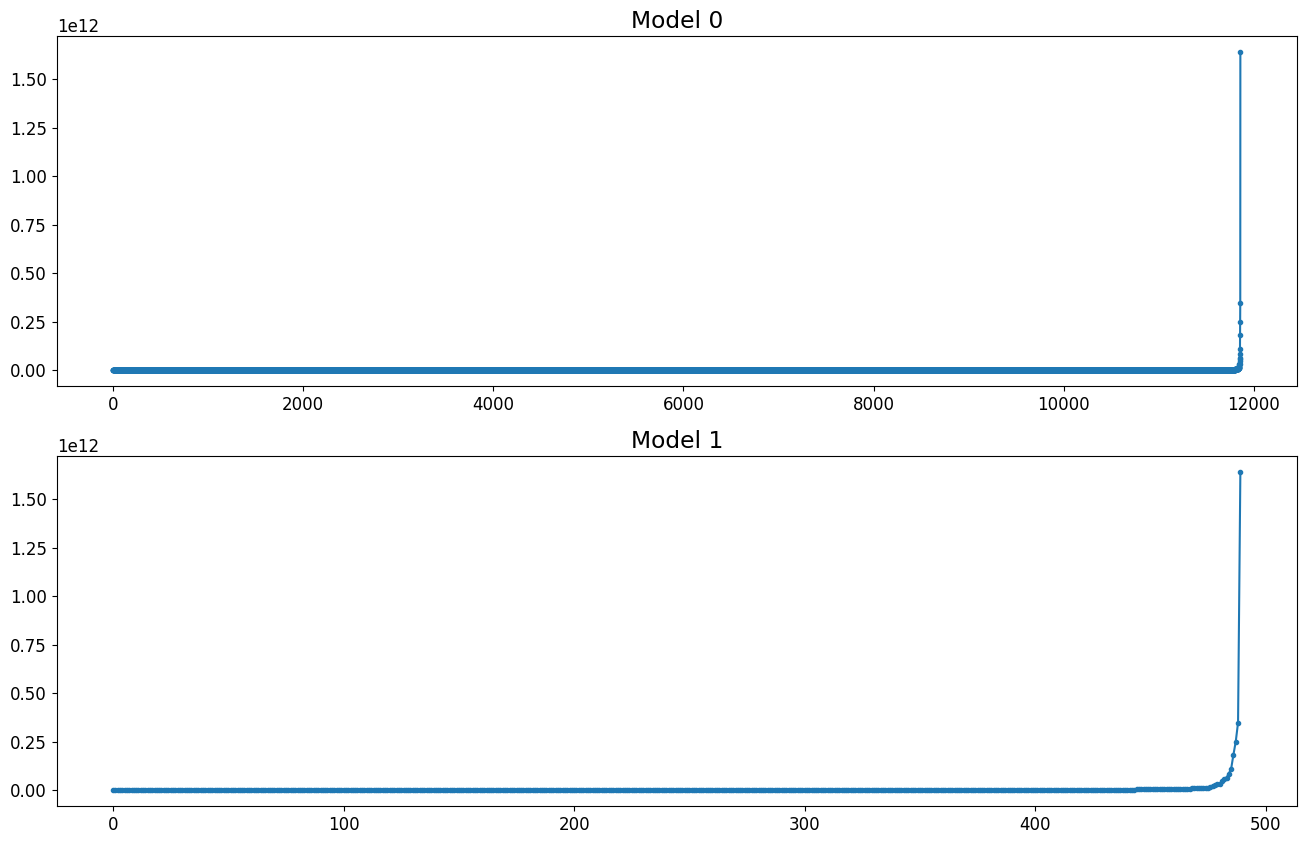

In [98]:
fig, ax = plt.subplots(2, 1)

ax[0].plot(alphas_0, marker = '.')
ax[0].set_title('Model 0')

ax[1].plot(alphas_1, marker = '.')
ax[1].set_title('Model 1')

plt.show()

Interval found by trial and error by looking at the coefficient of determination for all models given the values for alpha.

In [99]:
alphas_0 = alphas_0[11400:-14]
alphas_1 = alphas_1[50:-14]

In [100]:
print('Model 0:', len(alphas_0))
print('Model 1:', len(alphas_1))

Model 0: 445
Model 1: 426


In [101]:
print('Model 0 min/max:', alphas_0.min(), alphas_0.max())
print('Model 1 min/max:', alphas_1.min(), alphas_1.max())

Model 0 min/max: 377133966.40004396 16096517166.484985
Model 1 min/max: 28211214.130619645 14152490926.415863


In [102]:
models_0 = []
models_1 = []

for alpha in alphas_0:
    model = DecisionTreeRegressor(random_state = 42, ccp_alpha = alpha).fit(X_train, y_train)
    models_0.append(model)

for alpha in alphas_1:
    model = DecisionTreeRegressor(random_state = 42, ccp_alpha = alpha).fit(X_train, y_train)
    models_1.append(model)

In [103]:
train_scores_0 = [model.score(X_train, y_train) for model in models_0]
test__scores_0 = [model.score(X_test, y_test) for model in models_0]

train_scores_1 = [model.score(X_train, y_train) for model in models_1]
test__scores_1 = [model.score(X_test, y_test) for model in models_1]

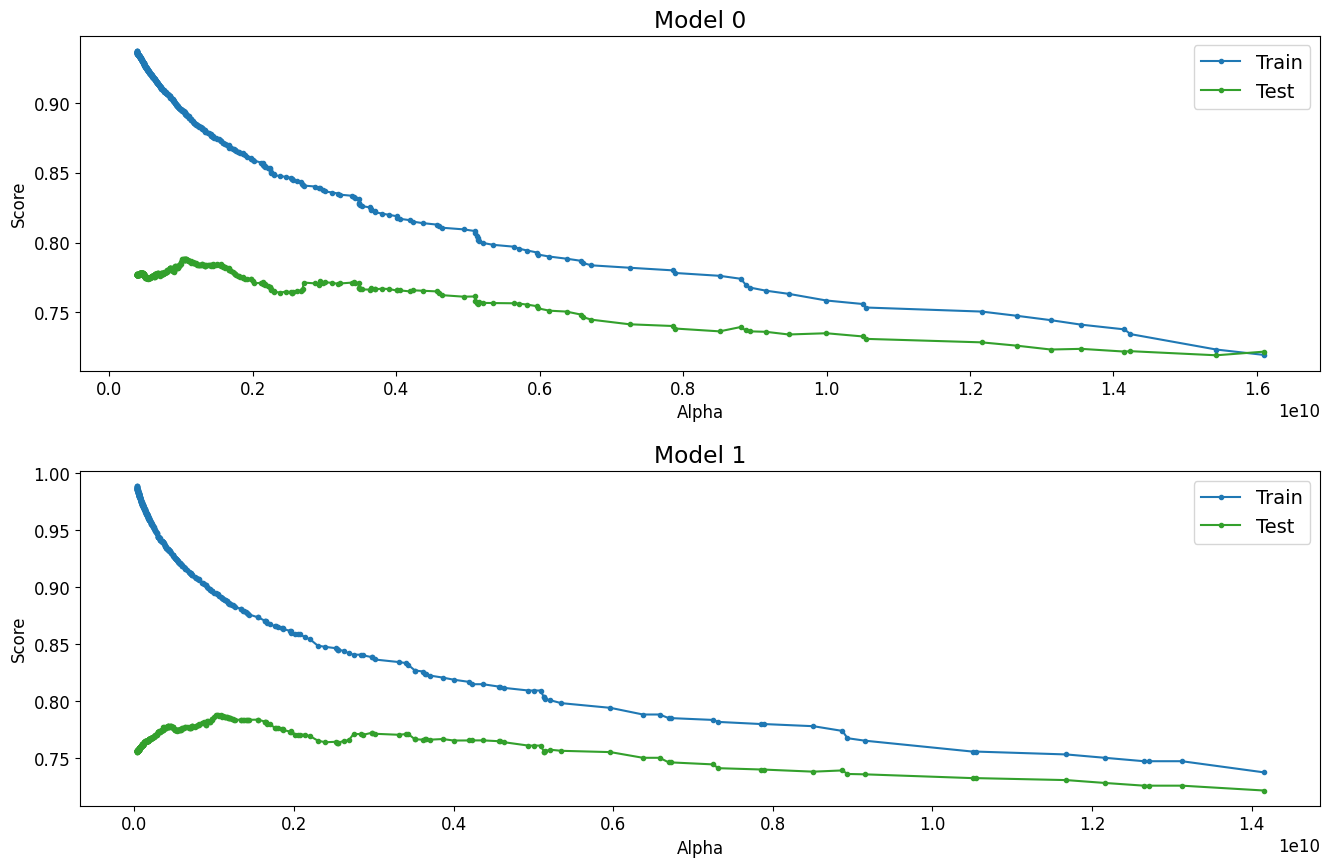

In [104]:
fig, ax = plt.subplots(2, 1)

ax[0].plot(alphas_0, train_scores_0, marker = '.', label = 'Train')
ax[0].plot(alphas_0, test__scores_0, marker = '.', label = 'Test')

ax[0].set_xlabel('Alpha')
ax[0].set_ylabel('Score')
ax[0].set_title('Model 0')
ax[0].legend()

ax[1].plot(alphas_1, train_scores_1, marker = '.', label = 'Train')
ax[1].plot(alphas_1, test__scores_1, marker = '.', label = 'Test')

ax[1].set_xlabel('Alpha')
ax[1].set_ylabel('Score')
ax[1].set_title('Model 1')
ax[1].legend()

fig.subplots_adjust(hspace = 0.3)
plt.show()

Performing four fold cross validation to find the optimal value for alpha.

In [105]:
cv_results_0 = []
cv_results_1 = []

for alpha in alphas_0:
    model = DecisionTreeRegressor(random_state = 42, ccp_alpha = alpha)
    scores = cross_val_score(model, X_train, y_train, cv = 4)
    cv_results_0.append([alpha, np.mean(scores)])

for alpha in alphas_1:
    model = DecisionTreeRegressor(random_state = 42, ccp_alpha = alpha)
    scores = cross_val_score(model, X_train, y_train, cv = 4)
    cv_results_1.append([alpha, np.mean(scores)])

In [106]:
cv_results_0_df = pd.DataFrame(cv_results_0, columns = ['Alpha', 'Mean Accuracy'])
cv_results_1_df = pd.DataFrame(cv_results_1, columns = ['Alpha', 'Mean Accuracy'])

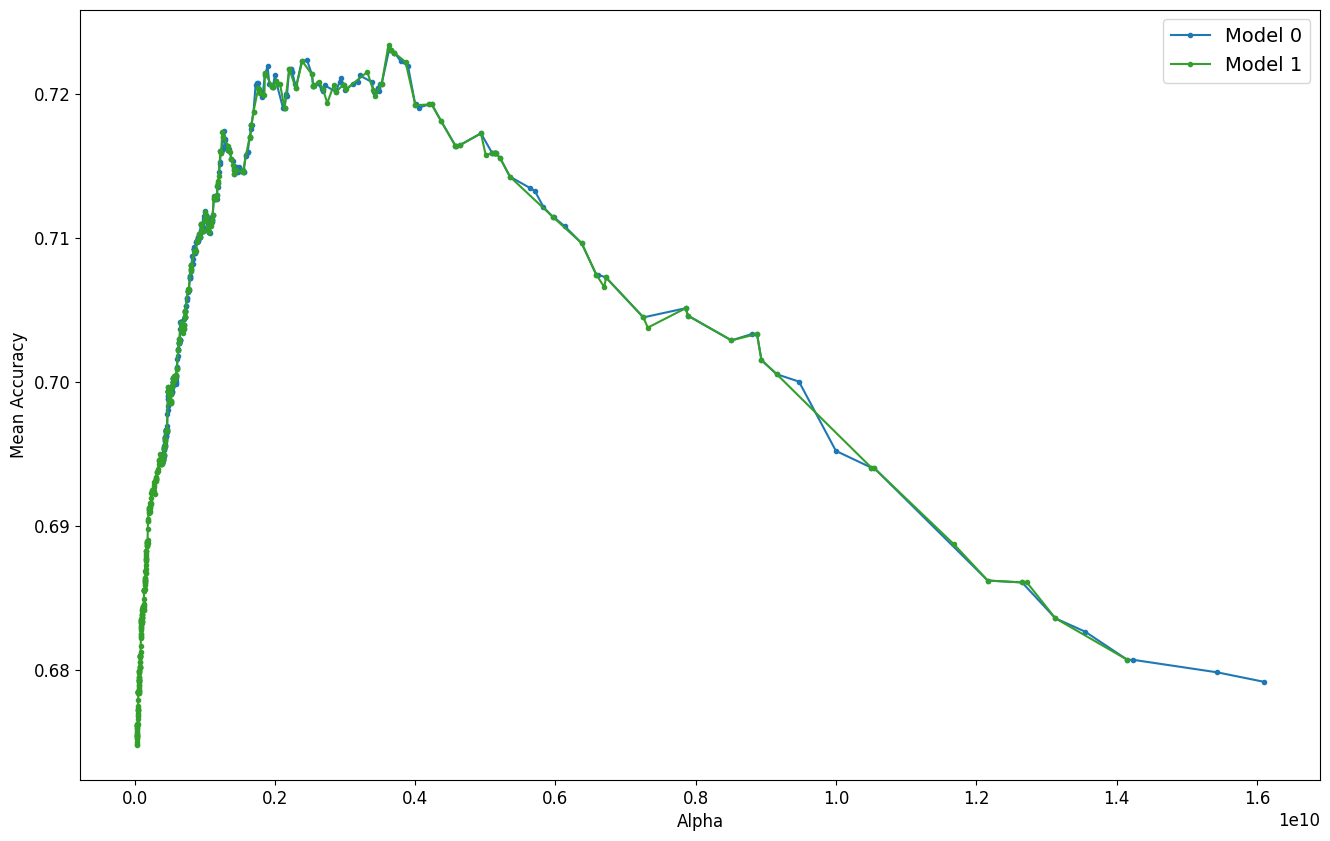

In [128]:
fig, ax = plt.subplots()

ax.plot(cv_results_0_df['Alpha'],
        cv_results_0_df['Mean Accuracy'],
        marker = '.', label = "Model 0")
ax.plot(cv_results_1_df['Alpha'],
        cv_results_1_df['Mean Accuracy'],
        marker = '.', label = "Model 1")

ax.set_xlabel('Alpha')
ax.set_ylabel('Mean Accuracy')
ax.legend()

plt.show()

In [108]:
best_accuracy_0 = cv_results_0_df['Mean Accuracy'].max()
best_accuracy_1 = cv_results_1_df['Mean Accuracy'].max()

optimal_alpha_0 = cv_results_0_df[cv_results_0_df['Mean Accuracy'] == best_accuracy_0]['Alpha'].iloc[0]
optimal_alpha_1 = cv_results_1_df[cv_results_1_df['Mean Accuracy'] == best_accuracy_1]['Alpha'].iloc[0]

print('Model 0 optimal alpha:\t', optimal_alpha_0)
print('Model 1 optimal alpha:\t', optimal_alpha_1)

Model 0 optimal alpha:	 3632224380.819832
Model 1 optimal alpha:	 3620267843.2950287


Defining the final MCCP models with their repective values for optimal alpha.

In [109]:
model_0_pruned = DecisionTreeRegressor(random_state = 42,
                                       ccp_alpha = optimal_alpha_0).fit(X_train, y_train)
model_1_pruned = DecisionTreeRegressor(random_state = 42,
                                       ccp_alpha = optimal_alpha_1).fit(X_train, y_train)

print('Pruned model 0, train score:\t', model_0_pruned.score(X_train, y_train))
print('Pruned model 0, test score:\t', model_0_pruned.score(X_test, y_test), '\n')
print('Pruned model 1, train score:\t', model_1_pruned.score(X_train, y_train))
print('Pruned model 1, test score:\t', model_1_pruned.score(X_test, y_test))

Pruned model 0, train score:	 0.8251988576232004
Pruned model 0, test score:	 0.7662998401032466 

Pruned model 1, train score:	 0.8260658468975688
Pruned model 1, test score:	 0.7663865485028776


In [135]:
model_0_pruned_pred_train = model_0_pruned.predict(X_train)
model_0_pruned_pred_test = model_0_pruned.predict(X_test)

print('MAE on train:\t', MAE(y_train, model_0_pruned_pred_train))
print('MAE on test:\t', MAE(y_test, model_0_pruned_pred_test))

MAE on train:	 574751.7953768354
MAE on test:	 631460.6077258432


In [136]:
model_1_pruned_pred_train = model_1_pruned.predict(X_train)
model_1_pruned_pred_test = model_1_pruned.predict(X_test)

print('MAE on train:\t', MAE(y_train, model_1_pruned_pred_train))
print('MAE on test:\t', MAE(y_test, model_1_pruned_pred_test))

MAE on train:	 573701.3419209264
MAE on test:	 631043.3627859723


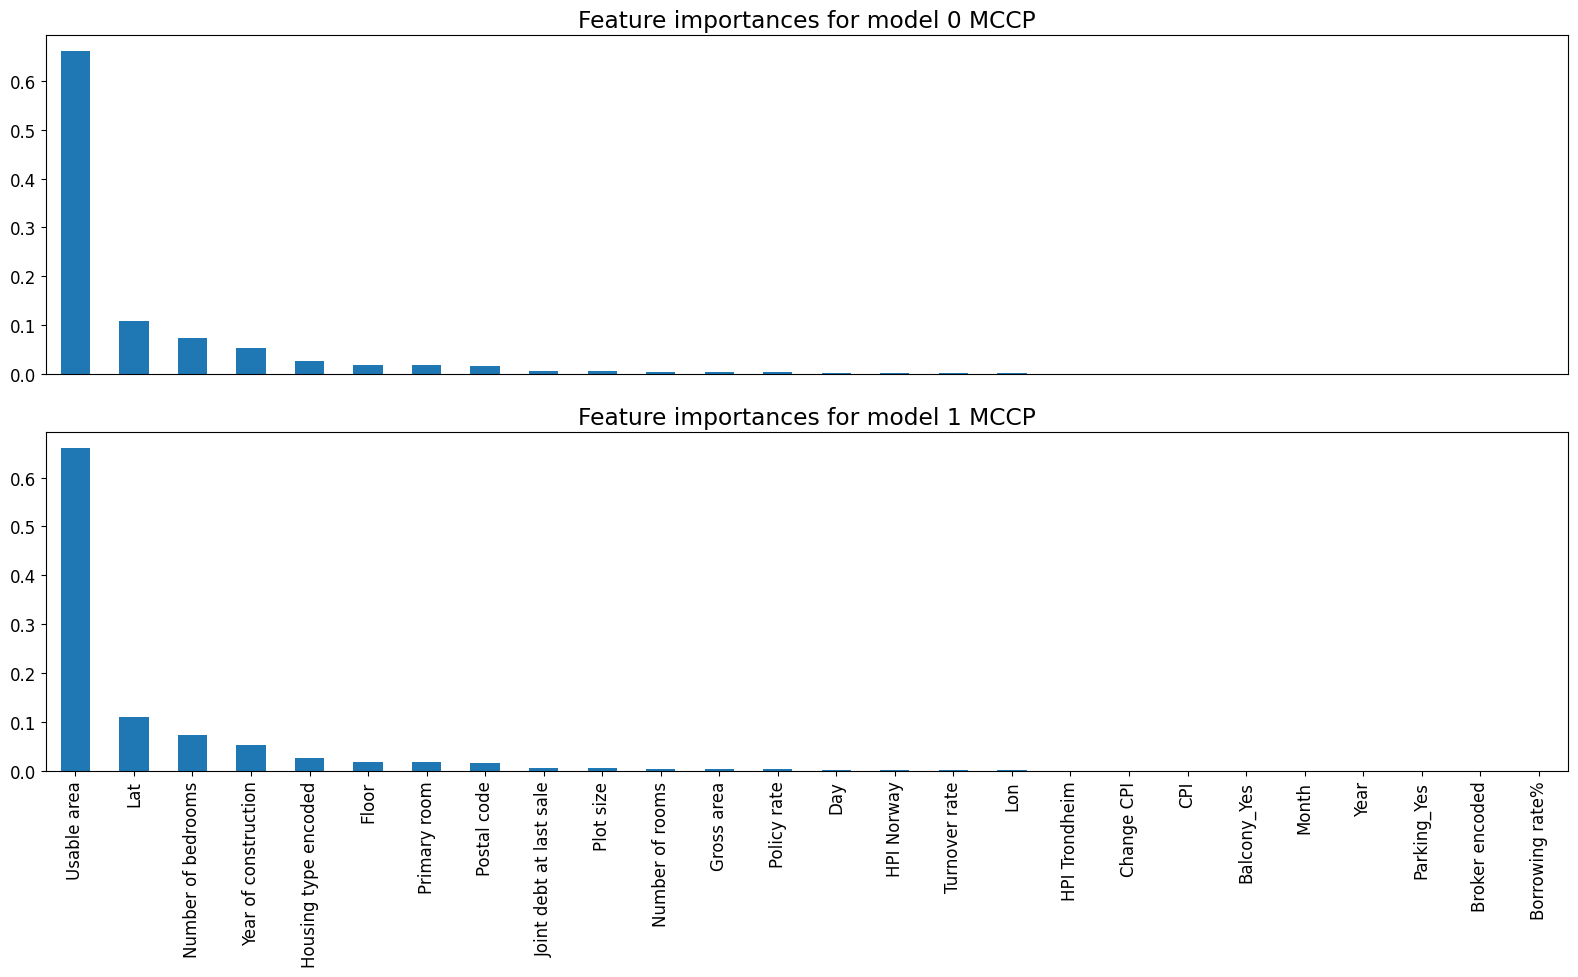

In [162]:
importances_m0_pruned = pd.DataFrame(model_0_pruned.feature_importances_,
                           columns = ['Importances'],
                           index = X_train.columns)
importances_m0_pruned.sort_values(by = ['Importances'], axis = 0,
                        ascending = False, inplace = True)

importances_m1_pruned = pd.DataFrame(model_1_pruned.feature_importances_,
                           columns = ['Importances'],
                           index = X_train.columns)
importances_m1_pruned.sort_values(by = ['Importances'], axis = 0,
                        ascending = False, inplace = True)

fig, ax = plt.subplots(2, 1)

importances_m0_pruned['Importances'].plot(kind = 'bar', ax = ax[0])
ax[0].set_title('Feature importances for model 0 MCCP')
ax[0].set_xticks([])

importances_m1_pruned['Importances'].plot(kind = 'bar', ax = ax[1])
ax[1].set_title('Feature importances for model 1 MCCP')

plt.tight_layout()
plt.show()

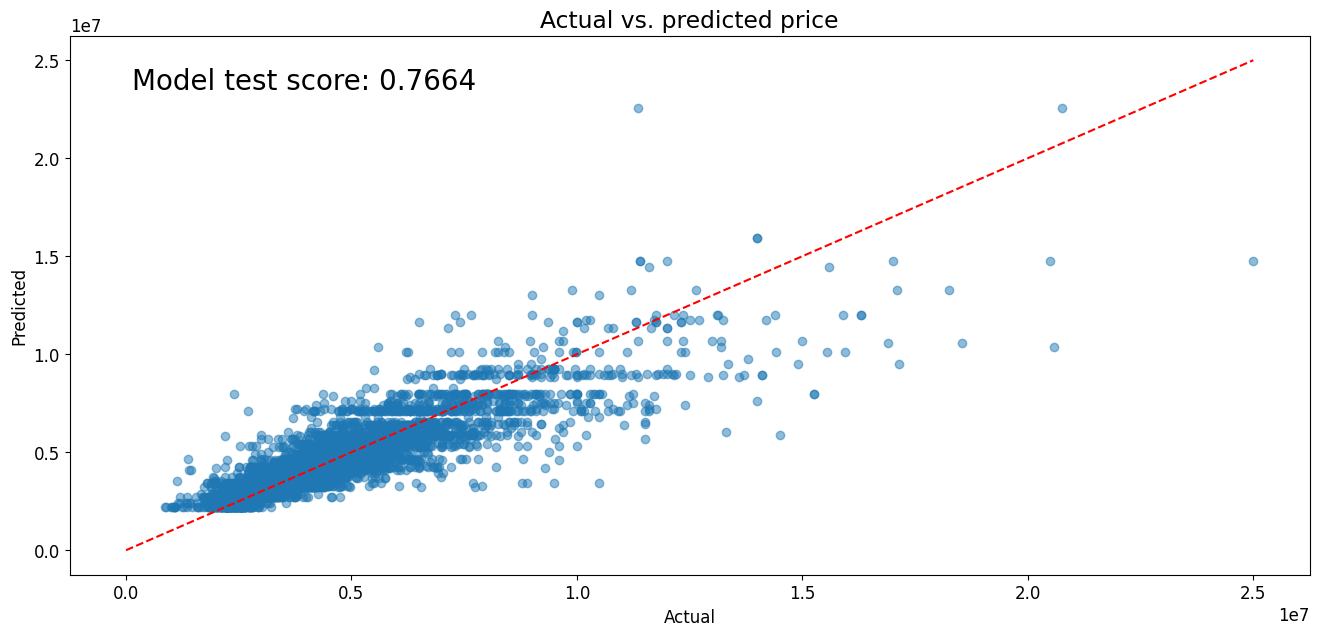

In [189]:
plt.figure(figsize = (16, 7))
plt.scatter(y_test, model_1_pruned_pred_test, alpha = .5)
plt.plot(np.linspace(0, y_test.max(), num = 2),
         np.linspace(0, y_test.max(), num = 2),
         color = 'red', linestyle = '--')

plt.text(0.05, 0.9, f'Model test score: {model_1_pruned.score(X_test, y_test):.4f}',
         transform=plt.gca().transAxes, fontsize=20, ha='left')

plt.title('Actual vs. predicted price')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

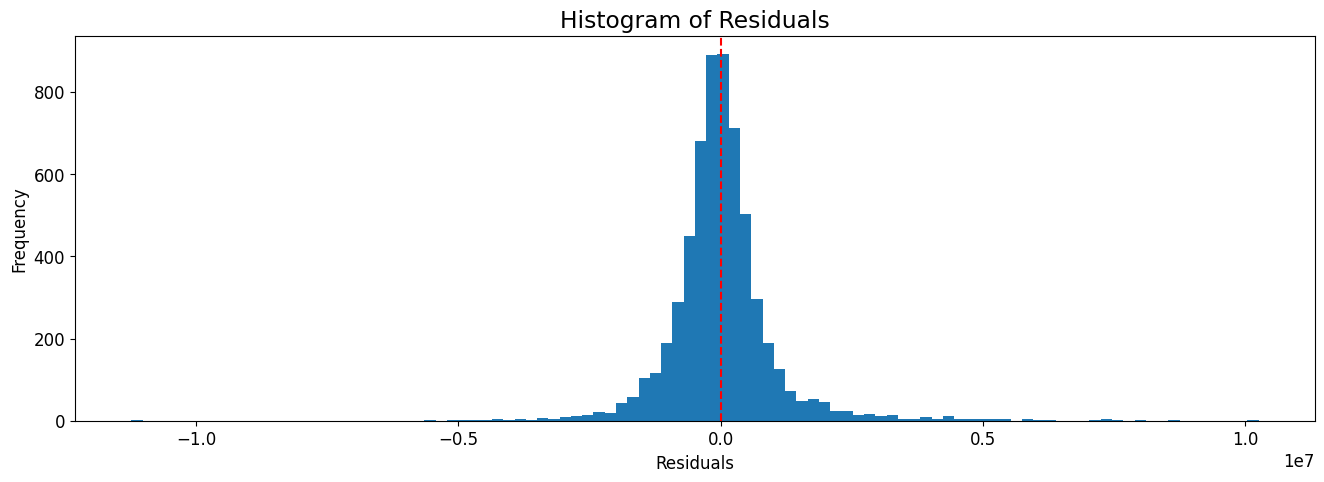

In [187]:
plt.figure(figsize = (16, 5))
plt.hist(y_test - model_1_pruned_pred_test, bins = 100)
plt.axvline(0, color = 'red', linestyle = '--')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

Plotting the final pruned trees.

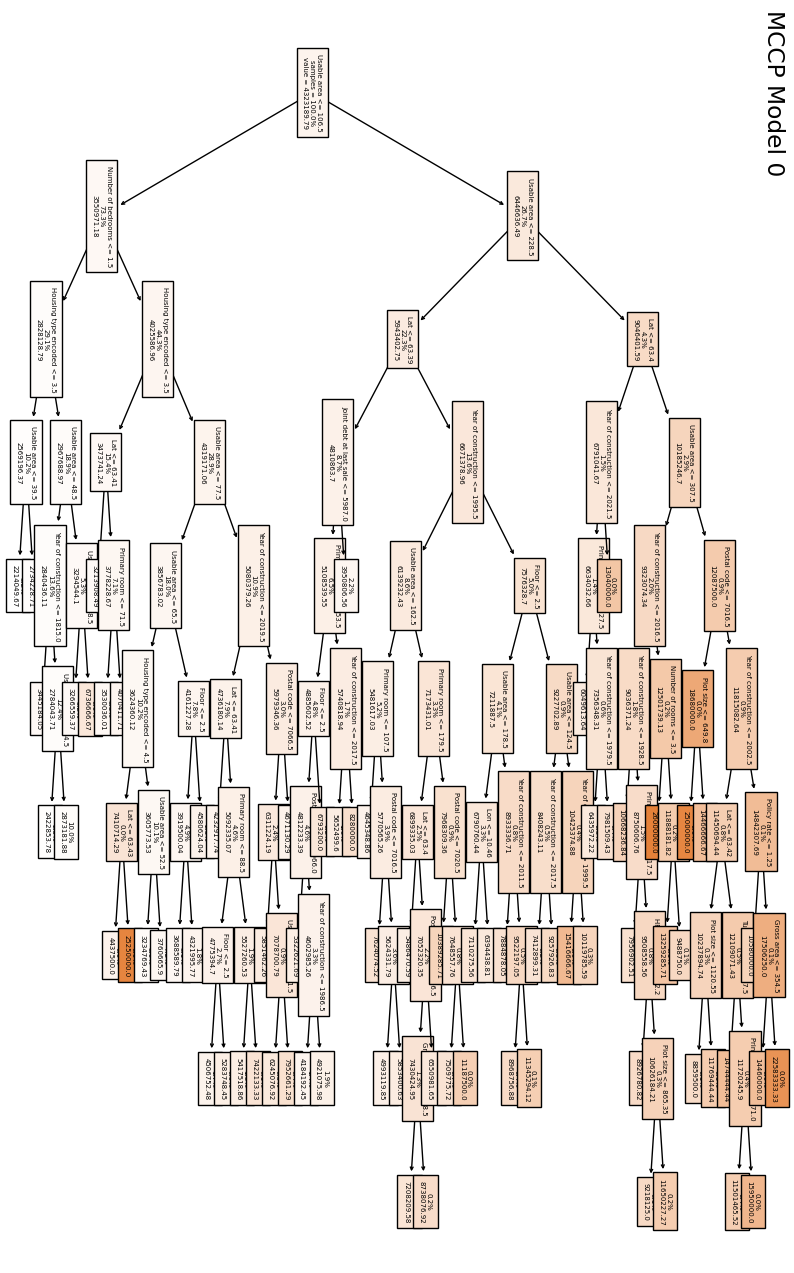

In [129]:
plt.figure(figsize=(10, 16))

plot_tree(model_0_pruned, fontsize = 5,
          filled = True, impurity = False,
          proportion = True, precision = 2,
          label = 'root', feature_names = X.columns)

for node in plt.gca().texts:
    node.set_rotation(270)

plt.title('MCCP Model 0', loc = 'right', rotation = 270, y = .88)
plt.show()

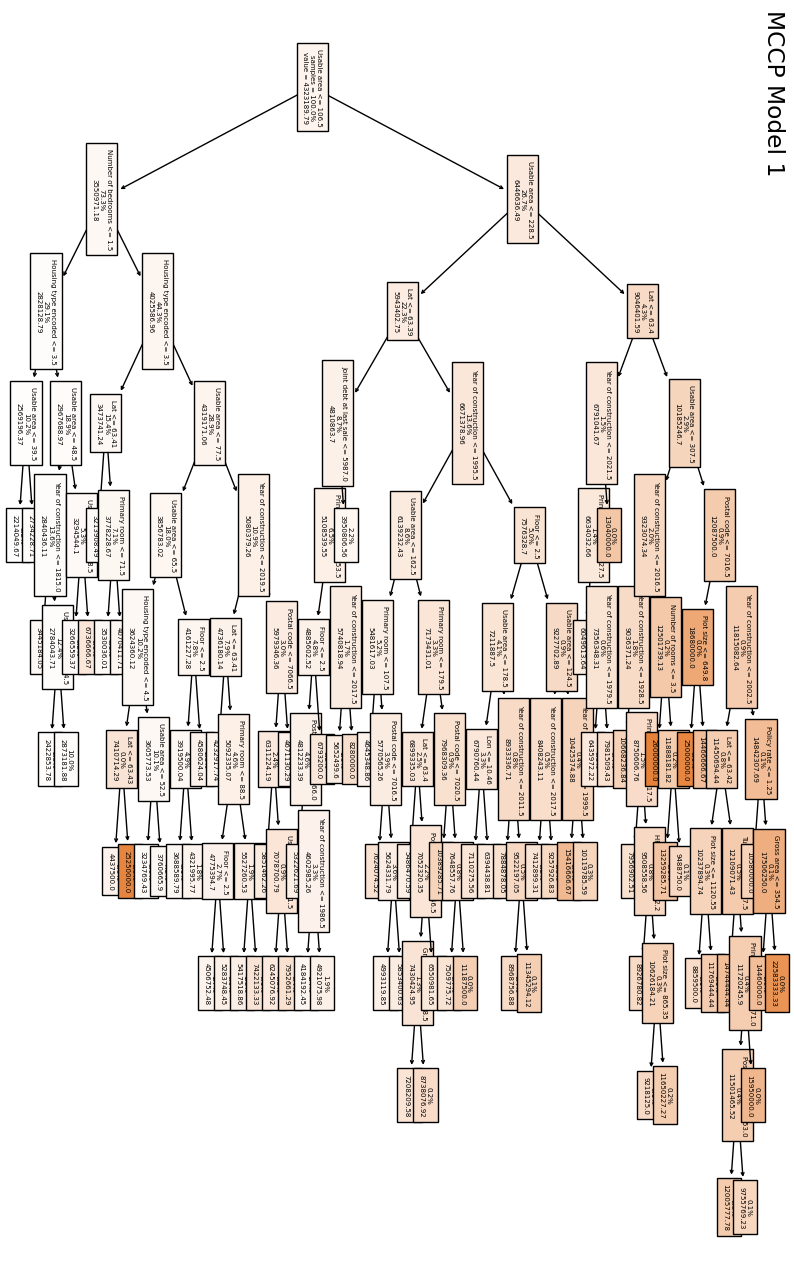

In [130]:
plt.figure(figsize=(10, 16))

plot_tree(model_1_pruned, fontsize = 5,
          filled = True, impurity = False,
          proportion = True, precision = 2,
          label = 'root', feature_names = X.columns)

for node in plt.gca().texts:
    node.set_rotation(270)

plt.title('MCCP Model 1', loc = 'right', rotation = 270, y = .88)
plt.show()